641264.4
-16.501


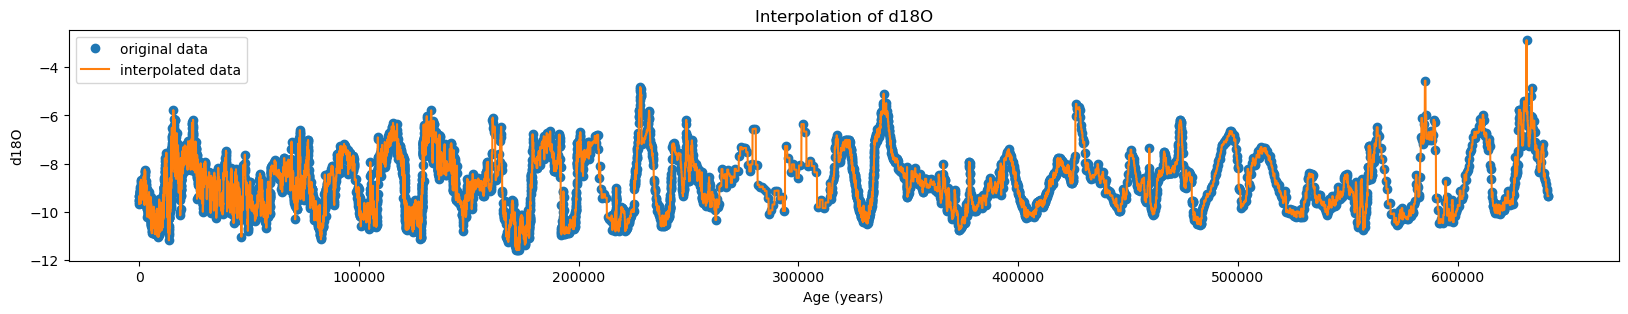

In [30]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

file_path = r"D:\VScode\bipolar_seesaw_CCM\other_data\monsoon.xlsx"
df = pd.read_excel(file_path)
df['age'] = df['age'] * 1000
print(np.max(df['age']))
print(np.min(df['age']))

col = df.columns[1] 

df = df[['age', col]].sort_values('age').reset_index(drop=True)



new_age = np.arange(0, 641260, 10)



f_interp = interp1d(df['age'], df[col],
                    kind='nearest',
                    bounds_error=False,
                    fill_value=1)
new_df = pd.DataFrame({'age': new_age,
                        col: f_interp(new_age)})

# plot df and new_df
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))
plt.plot(df['age'], df[col], 'o', label='original data')
plt.plot(new_df['age'], new_df[col], '-', label='interpolated data')
plt.xlabel('Age (years)')
plt.ylabel(col)
plt.title('Interpolation of ' + col)
plt.legend()
plt.show()

In [31]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt

def remove_orbital_component(df, col_name='d18O', cutoff=1/20000, order=4):
    """
    High-pass filter the specified column of a DataFrame to remove frequencies 
    below `cutoff` (yr⁻¹) and return a new DataFrame with 'age' and '{col_name}_hp'.

    Parameters
    ----------
    df : pandas.DataFrame
        Must have columns 'age' (evenly spaced in years) and `col_name`.
    col_name : str
        Name of the column to filter (default 'd18O').
    cutoff : float
        Cutoff frequency in yr⁻¹ (default 1/20000).
    order : int
        Order of the Butterworth filter (default 4).

    Returns
    -------
    pandas.DataFrame
        Two columns:
        - 'age' : same as input
        - '{col_name}_hp' : the high-pass filtered series
    """
    if 'age' not in df.columns or col_name not in df.columns:
        raise ValueError(f"DataFrame must contain 'age' and '{col_name}' columns.")

    age = df['age'].to_numpy()
    signal = df[col_name].to_numpy()

    # Ensure uniform sampling
    dt = np.diff(age)
    if not np.allclose(dt, dt[0]):
        raise ValueError("Age steps must be uniform to define a constant sampling rate.")
    fs = 1.0 / dt[0]         # samples per year
    nyq = fs / 2.0           # Nyquist frequency
    wn = cutoff / nyq        # normalized cutoff

    if wn <= 0 or wn >= 1:
        raise ValueError(f"Normalized cutoff wn={wn:.3e} invalid; check your cutoff and sampling rate.")

    # Design & apply zero-phase high-pass Butterworth
    b, a = butter(order, wn, btype='high', analog=False)
    filtered = filtfilt(b, a, signal)

    # Build output DataFrame with dynamic column name
    return pd.DataFrame({
        'age': age,
        f'{col_name}_hp': filtered
    })


import numpy as np
import pandas as pd

def threshold_to_noise(df, 
                       col='d18O', 
                       lower_pct=5, 
                       upper_pct=95, 
                       noise_mean=0,
                       sigma=0.5):
    """
    Replace values of df[col] below the lower_pct‐percentile or 
    above the upper_pct‐percentile with white noise.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame with at least the column `col`.
    col : str
        Name of the column to threshold.
    lower_pct : float
        Lower percentile cutoff (0–100).
    upper_pct : float
        Upper percentile cutoff (0–100).
    noise_mean : float
        Mean of the white‐noise distribution (default = 0).
    
    Returns
    -------
    df_out : pandas.DataFrame
        A copy of df where outliers in `col` are replaced by noise.
    lower_bound, upper_bound : float, float
        The thresholds actually used.
    """
    df_out = df.copy()
    series = df_out[col]
    
    # compute percentile thresholds
    lower_bound = np.percentile(series, lower_pct)
    upper_bound = np.percentile(series, upper_pct)
    
    # compute noise parameters
    # sigma = series.std()
    
    # mask of outliers
    mask = (series < lower_bound) | (series > upper_bound)
    n_outliers = mask.sum()
    
    # generate white noise for those positions
    noise = np.random.normal(loc=noise_mean, scale=sigma, size=n_outliers)
    
    # replace
    df_out.loc[mask, col] = noise
    
    print(f"Replaced {n_outliers} values <{lower_bound:.3f} or >{upper_bound:.3f} with N({noise_mean},{sigma:.3f}²) noise")
    return df_out, lower_bound, upper_bound


import numpy as np
import pandas as pd
from scipy.signal import find_peaks, lombscargle
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def plot_envelopes_and_psd(df):
    """
    For a DataFrame with two columns (age and signal), this function:
      1. Calculates upper and lower envelopes via peak/trough interpolation.
      2. Plots the original signal with its envelopes.
      3. Computes the Lomb-Scargle periodogram of both envelopes.
      4. Plots the PSD (log-log) of upper and lower envelopes.
    """
    # extract age and signal
    age = df.iloc[:, 0].values
    signal = df.iloc[:, 1].values

    # find local maxima (peaks) and minima (troughs)
    peaks, _ = find_peaks(signal)
    troughs, _ = find_peaks(-signal)

    # interpolate to get continuous envelopes
    up_env = interp1d(age[peaks], signal[peaks], kind='cubic',
                      bounds_error=False, fill_value='extrapolate')(age)
    lo_env = interp1d(age[troughs], signal[troughs], kind='cubic',
                      bounds_error=False, fill_value='extrapolate')(age)

    # 1) Plot original signal with envelopes
    plt.figure()
    plt.plot(age, signal, label='Original')
    plt.plot(age, up_env, label='Upper envelope')
    plt.plot(age, lo_env, label='Lower envelope')
    plt.xlabel('Age (yr)')
    plt.ylabel('Signal')
    plt.legend()
    plt.title('Signal with Upper and Lower Envelopes')
    plt.show()

    # 2) Compute Lomb-Scargle PSD for envelopes
    # define frequency array: from low freq ~1e-4 to Nyquist = 1/(2*dt)
    dt = np.mean(np.diff(age))
    nyquist = 1/(2*dt)
    freqs = np.linspace(1e-4, nyquist, 1000)
    ang_freqs = 2 * np.pi * freqs

    p_up = lombscargle(age, up_env, ang_freqs)
    p_lo = lombscargle(age, lo_env, ang_freqs)

    # 3) Plot PSD on log-log scale
    plt.figure()
    plt.loglog(freqs, p_up, label='Upper envelope PSD')
    plt.loglog(freqs, p_lo, label='Lower envelope PSD')
    plt.xlabel('Frequency (1/yr)')
    plt.ylabel('Lomb-Scargle Power')
    plt.legend()
    plt.title('Lomb-Scargle PSD of Envelopes')
    plt.show()




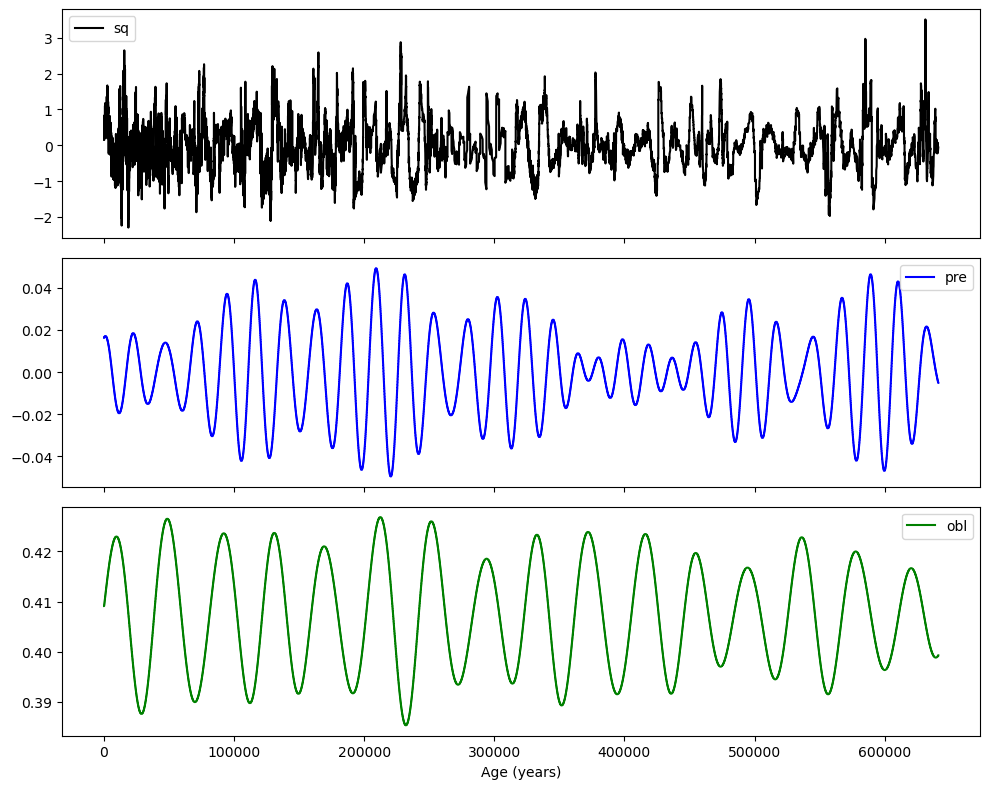

          age   d18O_hp
0           0  0.150830
1          10  0.231124
2          20  0.231418
3          30  0.311714
4          40  0.312011
...       ...       ...
64121  641210 -0.077534
64122  641220 -0.073614
64123  641230 -0.069705
64124  641240 -0.065807
64125  641250 -0.061921

[64126 rows x 2 columns]
          age       pre
0           0  0.016280
1          10  0.016280
2          20  0.016280
3          30  0.016280
4          40  0.016280
...       ...       ...
64121  641210 -0.005173
64122  641220 -0.005173
64123  641230 -0.005173
64124  641240 -0.005173
64125  641250 -0.005173

[64126 rows x 2 columns]
Length of df_sq_rs: 64126


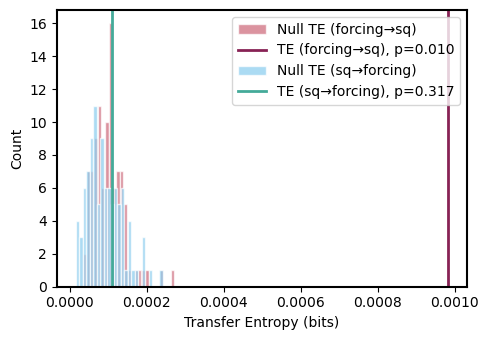

(True, <Figure size 500x350 with 1 Axes>)

In [34]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_hp = remove_orbital_component(new_df, col_name='d18O')

df_sq, df_pre, df_obl = sa.interpolate_data_forcing(df_hp, 10, if_plot=True)
print(df_sq)
print(df_pre)
# print the length of df_sq_rs and df_pre_rs
print('Length of df_sq_rs:', len(df_sq))


from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


pre = df_pre['pre'].values      # source (precession)
sq = df_sq['d18O_hp'].values    # target (residual)


result =sa.transfer_entropy_surrogate_test(pre,sq,forcing_bins=4)
result

Replaced 12826 values <-0.848 or >0.869 with N(0,0.100²) noise


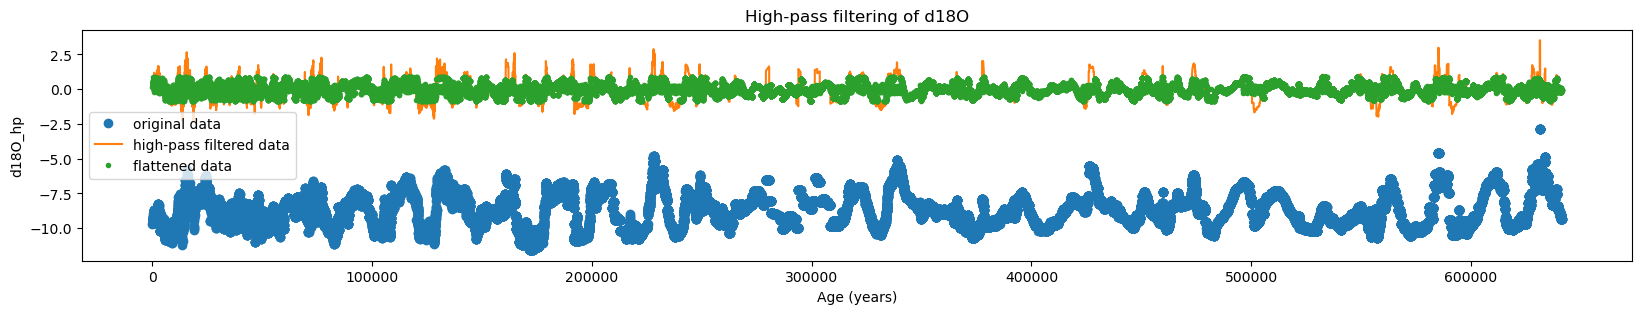

In [24]:

df_hp = remove_orbital_component(new_df, col_name='d18O')
df_flattened, _, _ = threshold_to_noise(df_hp, col=col + '_hp', lower_pct=10, upper_pct=90, noise_mean=0, sigma=0.1)
# plot new_df and df_hp
plt.figure(figsize=(20, 3))
plt.plot(new_df['age'], new_df[col], 'o', label='original data')
plt.plot(df_hp['age'], df_hp[col + '_hp'], '-', label='high-pass filtered data')
plt.plot(df_flattened['age'], df_flattened[col + '_hp'], '.', label='flattened data')
plt.xlabel('Age (years)')
plt.ylabel(col + '_hp')
plt.title('High-pass filtering of ' + col)
plt.legend()
plt.show()

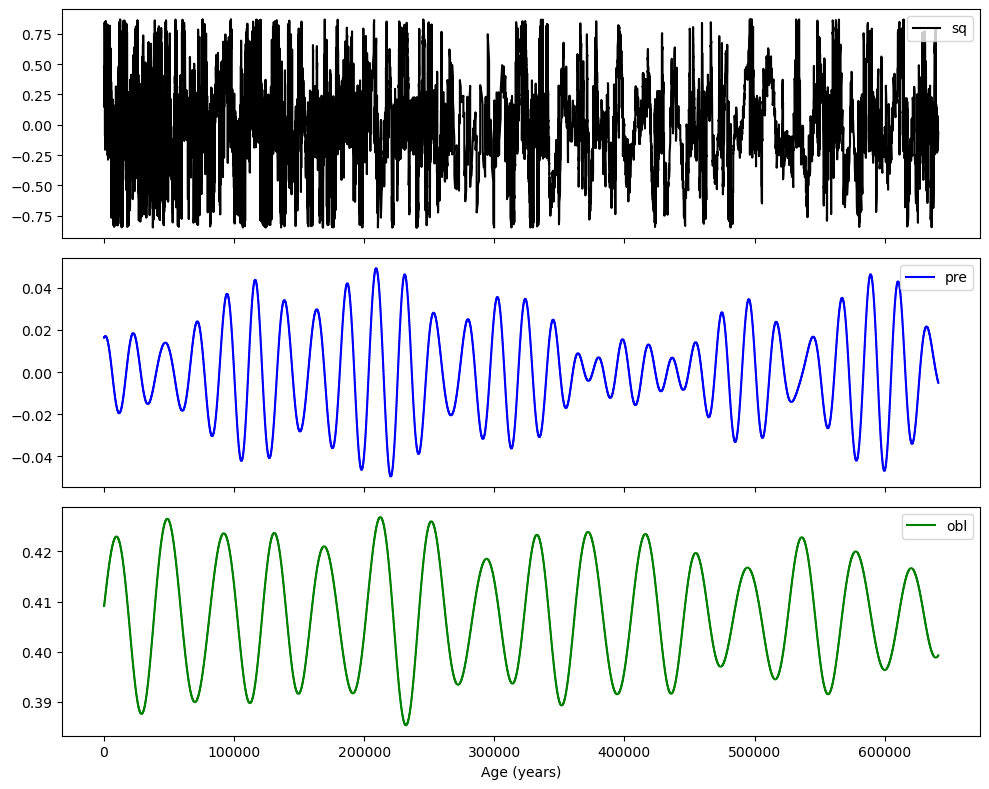

          age   d18O_hp
0           0  0.150830
1          10  0.231124
2          20  0.231418
3          30  0.311714
4          40  0.312011
...       ...       ...
64121  641210 -0.077534
64122  641220 -0.073614
64123  641230 -0.069705
64124  641240 -0.065807
64125  641250 -0.061921

[64126 rows x 2 columns]
          age       pre
0           0  0.016280
1          10  0.016280
2          20  0.016280
3          30  0.016280
4          40  0.016280
...       ...       ...
64121  641210 -0.005173
64122  641220 -0.005173
64123  641230 -0.005173
64124  641240 -0.005173
64125  641250 -0.005173

[64126 rows x 2 columns]
Length of df_sq_rs: 64126


In [25]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq, df_pre, df_obl = sa.interpolate_data_forcing(df_flattened, 10, if_plot=True)
print(df_sq)
print(df_pre)
# print the length of df_sq_rs and df_pre_rs
print('Length of df_sq_rs:', len(df_sq))

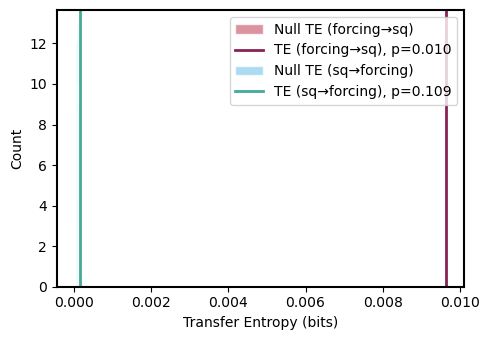

(True, <Figure size 500x350 with 1 Axes>)

In [26]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


pre = df_pre['pre'].values      # source (precession)
sq = df_sq['d18O_hp'].values    # target (residual)


result =sa.transfer_entropy_surrogate_test(pre,sq,forcing_bins=4)
result